In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from bound_funcs import *
from simulations import *

## Iterate on a realistic DGP

In [2]:
nz = 10
dgp = {
    'N': 10000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.95, .01, 2, .01]), 
    'wd': np.array([-1.1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([1.3, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([1.5, .05, 1.8, .05, .2, .5])
}

u = np.array([[0,-1], [-20, 0]])

metric='TNR'
id_strategies = ['IV', 'Manski']
regret_runs = run_sigmoid_dgp_simulation(dgp, u, metric, id_strategies, n_runs=10)
regret_df = regret_runs.groupby(['tag', 'ID_type']).mean().reset_index()

regret_df = regret_df.sort_values(by='tag', ascending=True)
regret_runs = regret_runs.sort_values(by='tag', ascending=True)




# Main result plot

In [ ]:
# Subgroup-level plot
bound_plot(metric, regret_df, regret_runs, save=False)

# Policy value plot

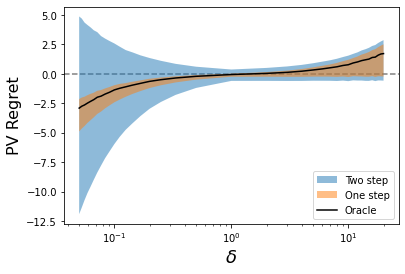

In [2]:
nz = 10
n_runs = 5

dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5])
}

id_strategies=['Manski']

results = pv_simulation(dgp, id_strategies, n_runs)

crdf = pd.concat(results)
crdf = crdf[crdf['tag'] == 'Population']
crdf = crdf.sort_values(by='cost_ratio')
crdf = crdf.groupby('cost_ratio').mean().reset_index()

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.fill_between(crdf['cost_ratio'], crdf['TS_down'],crdf['TS_up'], alpha=.5, label='Two step')
plt.fill_between(crdf['cost_ratio'], crdf['OS_down'],crdf['OS_up'], alpha=.5, label='One step')
plt.plot(crdf['cost_ratio'], crdf['R'], color='k', label='Oracle')
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('PV Regret', fontsize=16)
plt.savefig('figs/pv_regret.png', dpi=400, bbox_inches='tight')

In [6]:
## Policy value plot
N=15000
n_runs = 1
results = []
id_strategies=['Manski']

results = DAY_bernoulli_simulation(N, n_runs)

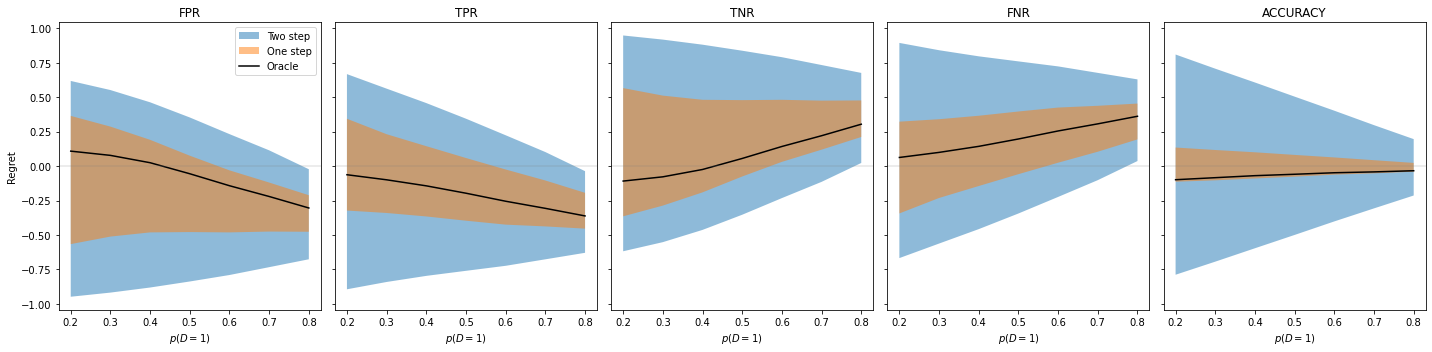

In [5]:
metrics = ['FPR', 'TPR', 'TNR', 'FNR', 'ACCURACY']
crdf = pd.DataFrame(results)
fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics):
    
    mdf = crdf[crdf['metric'] == metric]
    
    mdf = mdf[(mdf['ASD'] >= .15) & (mdf['ASD'] <= .85)]
    mdf['ASD'] = 1-mdf['ASD']
    mdf = mdf.sort_values(by='ASD', ascending=True)
    
    mdf['ASD_bin'] = mdf['ASD'].round(1)
    mdf = mdf.groupby(['ASD_bin']).mean().reset_index()

    axs[i].fill_between(mdf['ASD_bin'], mdf['TS_down'], mdf['TS_up'], alpha=.5, label='Two step')
    axs[i].fill_between(mdf['ASD_bin'], mdf['OS_down'],mdf['OS_up'], alpha=.5, label='One step')
    axs[i].plot(mdf['ASD_bin'], mdf[f'R'], color='k', label='Oracle')
    axs[i].set_title(metric)
    axs[i].axhline(color='grey', alpha=.2)
    
    axs[i].set_xlabel('$p(D=1)$')
    
    
    
axs[0].set_ylabel('Regret')
axs[0].legend()
plt.tight_layout()
plt.savefig('figs/metric_bound_plots.png', dpi=500, bbox_inches='tight')


## Numeric subgroup example 

In [6]:
dgp = {
    'pD': .19,
    'pA': .29,
    'pY': .1,
    'N': 30000
}

D = np.random.binomial(1, dgp['pD'], size=dgp['N'])
A = np.random.binomial(1, dgp['pA'], size=dgp['N'])
Y = np.random.binomial(1, dgp['pY'], size=dgp['N'])

RMAG =  np.random.binomial(1, .8, size=dgp['N'])
DA_corr =  np.random.binomial(1, .8, size=dgp['N'])
   
    
A[(D == 0) & (DA_corr == 1)] = 0

D[(A == 1) & (D == 0) & (Y == 1) & (RMAG == 1)] = 1 
A[(A == 1) & (D == 0) & (Y == 1) & (RMAG == 1)] = 0

vstats = get_v_stats(D, A, Y)

data = { 
    'D': D, 
    'Y': Y, 
    'A': A,
}

R_TS_down, R_TS_up = two_step_bounds(data, dgp, u, 'ACCURACY', id_strategy='Manski')
R_OS_down, R_OS_up = one_step_bounds(data, dgp, u, 'ACCURACY', id_strategy='Manski')

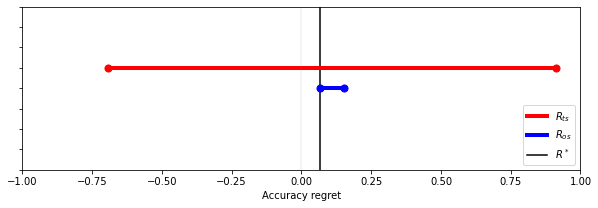

In [7]:

fig, ax = plt.subplots(figsize=(10,3))
R=oracle_regret(data, u, 'ACCURACY')

plt.plot([R_TS_down, R_TS_up], [0.05, 0.05], color='r', linestyle='-', label="$R_{ts}$",  linewidth=4)
plt.scatter(R_TS_down, 0.05,  color='r', s=50)
plt.scatter(R_TS_up, 0.05,  color='r', s=50)

plt.plot([R_OS_down, R_OS_up], [0, 0], color='b', linestyle='-', label="$R_{os}$",  linewidth=4)
plt.scatter(R_OS_down, 0,  color='b', s=50)
plt.scatter(R_OS_up, 0,  color='b', s=50)

plt.axvline(R, color='k', zorder=0, linestyle='-', label="$R^*$")

plt.axvline(color='grey', alpha=.1)
plt.ylim([-.2,.2])
plt.xlim([-1,1])
plt.legend(loc='lower right')
plt.xlabel("Accuracy regret")
plt.ylabel("")
ax.set(yticklabels=[]) 

plt.savefig('examples.pdf', dpi=600)

## MSM bounds

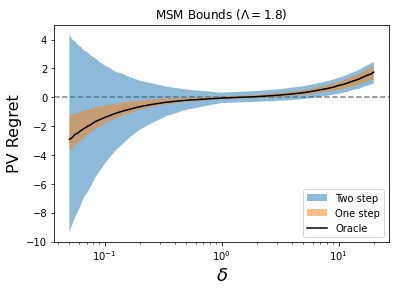

In [131]:
nz = 10
n_runs = 10
Lambda = 1.8
dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5]),
    'lambda': 1.8
}

results = []
id_strategies=['MSM']

results = pv_simulation(dgp, id_strategies, n_runs)
crdf = pd.concat(results)
crdf = crdf[crdf['tag'] == 'Population']
crdf = crdf.sort_values(by='cost_ratio')
crdf = crdf.groupby('cost_ratio').mean().reset_index()

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.fill_between(crdf['cost_ratio'], crdf['TS_down'], crdf['TS_up'], alpha=.5, label='Two step')
plt.fill_between(crdf['cost_ratio'], crdf['OS_down'], crdf['OS_up'], alpha=.5, label='One step')
plt.plot(crdf['cost_ratio'], crdf['R'], color='k', label='Oracle')
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('PV Regret', fontsize=16)
plt.title(f'MSM Bounds ($\Lambda={Lambda}$)')
plt.savefig('figs/msm_pv_regret.png', dpi=400, bbox_inches='tight')

## Iterate over different values of lambda

In [ ]:
nz = 10
n_runs = 10

dgp = {
    'N': 15000,
    'nz': nz,
    'beta': 2.5*(1/nz) ,
    'wa': np.array([-1.6, .01, 2, .01]), 
    'wd': np.array([-1, 1.7, .01, 1.5, .2, .2]),
    'w_mu1': np.array([.12, .8, .02, .9, .3, .6]),
    'w_mu0': np.array([.33, .05, 1.8, .05, .2, .5]),
}

design_results = []
id_strategies=['MSM']
lambdas = np.arange(1, 4, .02)

# for lam in lambdas:

for lam in lambdas:
    dgp['lambda'] = lam
    design_results.extend(pv_simulation(dgp, id_strategies, n_runs))

crdf = pd.concat(design_results)
crdf = crdf[crdf['tag'] == 'Population']
crdf['TS_includes_zero'] = ((crdf['TS_down'] <= 0) & (crdf['TS_up'] >= 0)).astype(int)
crdf['OS_includes_zero'] = ((crdf['OS_down'] <= 0) & (crdf['OS_up'] >= 0)).astype(int)



In [ ]:
CR=5
crdf = pd.concat(design_results)
crdf = crdf[crdf['tag'] == 'Population']
crdf['TS_includes_zero'] = ((crdf['TS_down'] <= 0) & (crdf['TS_up'] >= 0)).astype(int)
crdf['OS_includes_zero'] = ((crdf['OS_down'] <= 0) & (crdf['OS_up'] >= 0)).astype(int)

sdf = crdf[(crdf['tag'] == 'Population') & (crdf['cost_ratio'] == CR)]
sdf = sdf.groupby(['cost_ratio', 'lambda']).mean().reset_index()
sdf['TS_includes_zero'] = ((sdf['TS_down'] <= 0) & (sdf['TS_up'] >= 0)).astype(int)
sdf['OS_includes_zero'] = ((sdf['OS_down'] <= 0) & (sdf['OS_up'] >= 0)).astype(int)
TS_lambda_star = sdf[sdf['TS_includes_zero'] == 1]['lambda'].min()
OS_lambda_star = sdf[sdf['OS_includes_zero'] == 1]['lambda'].min()

crdf = pd.concat(design_results)
crdf = crdf[(crdf['tag'] == 'Population') & (crdf['cost_ratio'] == CR)]

plt.text(TS_lambda_star+.05, -1.1, '$\Lambda^*_{TS}$', fontsize=14)
plt.text(OS_lambda_star+.05, -1.1, '$\Lambda^*_{OS}$', fontsize=14)

crdf = crdf.sort_values(by='lambda')
crdf = crdf.groupby('lambda').mean().reset_index()

plt.fill_between(crdf['lambda'], crdf['TS_down'], crdf['TS_up'], alpha=.5, label='Two step')
plt.fill_between(crdf['lambda'], crdf['OS_down'], crdf['OS_up'], alpha=.5, label='One step')
plt.plot(crdf['lambda'], crdf['R'], color='k', label='Oracle')

plt.axhline(0, color='grey', zorder=1, linestyle='--')
plt.axvline(TS_lambda_star, color='k', zorder=1, linestyle='-')
plt.axvline(OS_lambda_star, color='k', zorder=1, linestyle='-')


plt.xlabel('$\Lambda$', fontsize=16)
plt.ylabel('PV Regret', fontsize=16)
plt.legend(loc='upper right')
plt.title(f'MSM Bounds ($\delta=5$)')

plt.savefig('figs/pv_lambda_slider.png', dpi=400, bbox_inches='tight')

# Fix cost ratio, vary lambda, include virtical line for Lambda^*

## Design sensitivity plot

In [ ]:

ls_results = []

for cr in crdf['cost_ratio'].unique():
    for run in crdf['run'].unique():
        crslice = crdf[(crdf['cost_ratio'] == cr) & (crdf['run'] == run)]
        ts_lambda_star = crslice[crslice['TS_includes_zero'] == 1]['lambda'].min()
        os_lambda_star = crslice[crslice['OS_includes_zero'] == 1]['lambda'].min()

        ls_results.append({
            'cr': cr,
            'Two step': ts_lambda_star,
            'One step': os_lambda_star,
            'run': run
        })
    lsdf = pd.DataFrame(ls_results)
    
lsdf = lsdf.sort_values(by='cr')
lsdf = lsdf.melt(id_vars=['cr', 'run'])

sns.lineplot(data=lsdf, x="cr", y="value", hue='variable')
plt.xlabel('$\delta$', fontsize=18)
plt.ylabel('$\Lambda^{*}$', fontsize=16)
plt.xscale('log',base=10) 
plt.legend(loc='lower right')

plt.savefig('figs/pv_lambds_delta_slider.png', dpi=400, bbox_inches='tight')